# fROCI Dynamic Issuance Policy 

## Introduction

The aim here is to create a dynamic supply policy for fROCI. Generally, administering any changes to supply of fROCI tokens will either require the owner of the ROCI NFT to change it manually (or) if they setup a governance process around it, then a vote from fROCI token holders to help decide any changes to fROCI supply. While this makes sense for active participants of the those involved in the Rocinante's mission profile and journey to Ganymede, for passive holders, there may not necessarily be any confidence that any voting process will end in a responsible and predictable supply policy change. 

A dynamic fROCI issuance policy ensures, tokens are minted and burned autonomously based on an invariant (or) conservation ratio defined by the reserve balance and current market capitalisation of fROCI. This minimises the governance decisions and processes ensuring both active and passive participants can rely on a smooth issuance process of fROCI tokens without the worry of any inflation or deflation in token price.

In this model we differentiate the fROCI supply into two pools, the reserve pool and the circulating supply pool. We model revenue to the Rocinante digital economic system as parameter to show how the system would behave when revenues exceed expenses, and we treat expenses as a fixed percent rate from the reserve over time based on the calculation in the Rocinante Reserve split table. This abstraction of expenses represents a **maximum possible rate per year of expenses**, though in practice the real expenses rate would tend to vary depending on any uncertain scenarios on the way to Ganymede, or for a proposal to recieve some support but ultimately fails to reach sufficient support to execute. Never the less, this creates an expenses limit, and by modulating issuance based on revenues and expenses, we can also understand it as an issuance boundary. 

For further information regarding the background of this model please refer to the links in the README.md file.

## State Variables

We define three state variables, the reserve pool balance, the circulating supply pool balance and net_income. All of these variables are denominated in fROCI.  


In [1]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
genesis_states = {
    'reserve': 13000000, # Current common pool/reserve balance
    'circulation': 39000000, # Total fROCI supply minus common pool/reserve balance (26238 - 7473)
    'net_income': 0.0,
    'adjustment':0.0
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Model Params
We define some parameters which can be used to tune the behavior of issuance and distribution in the model 

In [2]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
params = {
    'expenses_rate': [0.12], # 125,000/1,041,666.67 UND per month #[0.1], # proportion of common pool funds (reserve) that leave each timestep (month)
    'revenues': [0.009], # proportion of circulating supply that is moved to the common pool each timestep, used to show how burning kicks in when inflows exceed outflows while. 
    'throttle': [0.0], # maximimum proportion of the total supply that can be issued or burned in each timestep (month), using 0 will disable throttling and max issuance will be a function of the max outflow rate.
    'target_reserve_ratio': [1/3] # target ratio of common pool funds to total supply
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Timestep
We assume that each timestep in cadcad represents 1 month in real time, scaling model parameters to reflect that timescale. 

# Policies and State Update Functions

We define a supply policy and four state update fuctions. 


In [3]:
def supply_policy(params, step, sH, s):
    # first we calculate net flows
    outflow_rate = params['outflow_rate']
    outflow = s['reserve'] * outflow_rate
    netflow = params['inflow'] * s['circulation'] - outflow

    # then we calculate supply adjustments 
    reserve = s['reserve'] + netflow 
    circulation = s['circulation'] - netflow
    supply = reserve + circulation
    ratio = reserve / supply
    

    # Proportional control https://en.wikipedia.org/wiki/Proportional_control
    # corrections are made proportionally to the difference between the target and the current value

    if params['throttle'] != 0: 
        # Corrections bounded by a maximum issuance rate parameter 
        e = params['target_reserve_ratio'] - ratio
        if e < 0:
            adjustment = max(e, -params['throttle']) * supply
        else:
            adjustment = min(e, params['throttle']) * supply 
    else:
        # Corrections are unbounded, issuance is bounded by the maximum outflow rate 
        e = params['target_reserve_ratio'] - ratio 
        adjustment = e * supply 


    return ({'netflow':netflow, 'adjustment':adjustment})


def update_reserve(params, step, sH, s, _input):
    key = 'reserve'
    value = s['reserve'] + _input['netflow'] + _input['adjustment']
    return (key, value)

def update_circulation(params, step, sH, s, _input):
    key = 'circulation'
    value = s['circulation'] - _input['netflow']
    return (key, value)

def update_netflow(params, step, sH, s, _input):
    key = 'netflow'
    value =  _input['netflow']
    return (key, value)

def update_adjustment(params, step, sH, s, _input):
    key = 'adjustment'
    value =  _input['adjustment']
    return (key, value)

# Partial State Update Blocks


In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel
partial_state_update_blocks = [
    { 
        'policies': {
            'driver': supply_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            'reserve': update_reserve,
            'circulation': update_circulation,
            'netflow': update_netflow,
            'adjustment': update_adjustment
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Simulation Configuration Parameters
Lastly, we define the number of timesteps and the number of Monte Carlo runs of the simulation. These parameters must be passed in a dictionary, in `dict_keys` `T` and `N`, respectively. In our example, we'll run the simulation for 10 timesteps. And because we are dealing with a deterministic system, it makes no sense to have multiple Monte Carlo runs, so we set `N=1`. We'll ignore the `M` key for now and set it to an empty `dict`

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's omit it
sim_config_dict = {
    'T': range(120),
    'N': 1,
    'M': params
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Putting it all together
We have defined the state variables of our system and their initial conditions, as well as the state update functions, which have been grouped in a single state update block. We have also specified the parameters of the simulation (number of timesteps and runs). We are now ready to put all those pieces together in a `Configuration` object.

In [6]:
#imported some addition utilities to help with configuration set-up
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

exp = Experiment()
c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
del configs[:]
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

# Running the engine
We are now ready to run the engine with the configuration defined above. Instantiate an ExecutionMode, an ExecutionContext and an Executor objects, passing the Configuration object to the latter. Then run the `execute()` method of the Executor object, which returns the results of the experiment in the first element of a tuple.

In [7]:
%%capture
from cadCAD.engine import ExecutionMode, ExecutionContext
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)

from cadCAD.engine import Executor

simulation = Executor(exec_context=local_mode_ctx, configs=configs) # Pass the configuration object inside an array
raw_system_events, tensor_field, sessions = simulation.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


# Analyzing the results
We can now convert the raw results into a DataFrame for analysis

In [8]:
%matplotlib inline
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

reserve   circulation       netflow  \
subset run timestep substep                                             
0      1   0        0        1.250000e+07  7.350000e+07  0.000000e+00   
           1        1        2.866667e+07  7.433850e+07 -8.385000e+05   
           2        1        3.433506e+07  7.710945e+07 -2.770953e+06   
           3        1        3.714817e+07  8.053568e+07 -3.426222e+06   
           4        1        3.922795e+07  8.426863e+07 -3.732959e+06   
...                                   ...           ...           ...   
           116      1        6.777022e+09  1.451052e+10 -6.519757e+08   
           117      1        7.095847e+09  1.519317e+10 -6.826479e+08   
           118      1        7.429671e+09  1.590793e+10 -7.147631e+08   
           119      1        7.779200e+09  1.665632e+10 -7.483892e+08   
           120      1        8.145173e+09  1.743992e+10 -7.835972e+08   

                               adjustment  simulation  
subset run timestep substep                            
0      1   0        0        0.000000e+00           0  
           1        1        1.700517e+07           0  
           2        1        8.439342e+06           0  
           3        1        6.239336e+06           0  
           4        1        5.812738e+06           0  
...                                   ...         ...  
           116      1        9.564757e+08           0  
           117      1        1.001473e+09           0  
           118      1        1.048588e+09           0  
           119      1        1.097918e+09           0  
           120      1        1.149570e+09           0  

[121 rows x 5 columns]

<AxesSubplot:xlabel='timestep'>

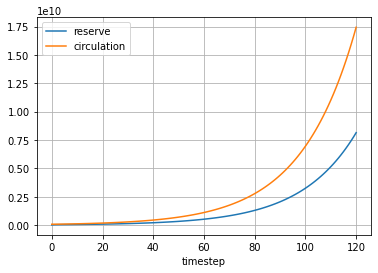

In [9]:
simulation_result.plot('timestep', ['reserve', 'circulation'], grid=True)

<AxesSubplot:xlabel='timestep'>

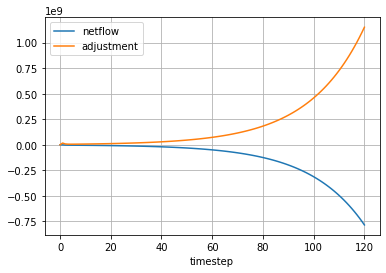

In [10]:
simulation_result.plot('timestep', ['netflow', 'adjustment'], grid=True)